This notebook load raw ADC radar data and produce Range-Doppler, Angle-Doppler, and Range-Angle map. Then use 2D-CFAR extract the object from Range-Angle map.

Dataset: 
[UWCR](https://github.com/Xiangyu-Gao/Radar-multiple-perspective-object-detection/tree/aff04b354f07f2689dfd8fcf6fcb68a9404eb73a)

Provide:   
1. Function for producing Range-Doppler
2. Function for producing Angle-Doppler
3. Function for producing Range-Angle
4. Function for projecting gt object (x, y) in meters to Range-Angle map
5. 2D-CFAR

Ref:   

[1] https://github.com/Xiangyu-Gao/Radar-multiple-perspective-object-detection/blob/main/slice3d.py#L151  
[2] https://github.com/ravikothari510/crossattention_radar_detector/blob/main/Utils/CFAR/OS_CFAR_2D.py


In [106]:
import os
import numpy as np
import scipy
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import PIL.Image as Image
import cv2

In [107]:
IMG_DIR = 'images_0'
RAW_RADAR_DIR = 'radar_raw_frame'
LABEL_DIR = 'text_labels'
# Define the data path
data_path = 'data/UWCR/Automotive/'
dir_name = '2019_04_09_bms1000'
idx = 20

In [108]:
# Radar configuration
n_angle = 128
n_vel = 128
n_range = 128
n_chirp = 255
n_ant = 8  # number of antennas = n_tx * n_rx
n_sample = 128
noma_rcs = 30000

In [109]:
file_dir = os.path.join(data_path, dir_name, RAW_RADAR_DIR)
files = sorted(os.listdir(file_dir))
print('Top 10 files:', files[:10])

Top 10 files: ['000003.mat', '000004.mat', '000005.mat', '000006.mat', '000007.mat', '000008.mat', '000009.mat', '000010.mat', '000011.mat', '000012.mat']


In [110]:
img_dir = os.path.join(data_path, dir_name, IMG_DIR)
img_files = sorted(os.listdir(img_dir))
print('Top 10 files:', img_files[:10])

Top 10 files: ['0000000000.jpg', '0000000001.jpg', '0000000002.jpg', '0000000003.jpg', '0000000004.jpg', '0000000005.jpg', '0000000006.jpg', '0000000007.jpg', '0000000008.jpg', '0000000009.jpg']


In [111]:
label_dir = os.path.join(data_path, dir_name, LABEL_DIR)
label_filts = sorted(os.listdir(label_dir))
print('Top 10 files:', label_filts[:10])

Top 10 files: ['0000000000.csv', '0000000003.csv', '0000000004.csv', '0000000005.csv', '0000000006.csv', '0000000007.csv', '0000000008.csv', '0000000009.csv', '0000000010.csv', '0000000011.csv']


In [112]:
file = files[idx]
print('Radar file:', file)

file_name = file.split('.')[0]

img_file = f'0000{file_name}.jpg'
print('Image file:', img_file)

label_file = f'0000{file_name}.csv'
print('Label file:', label_file)

Radar file: 000023.mat
Image file: 0000000023.jpg
Label file: 0000000023.csv


In [113]:
# Load the first .mat file
file_path = os.path.join(file_dir, file)

# Load the .mat file
mat = spio.loadmat(file_path, squeeze_me=True)
print('Keys:', mat.keys())

ADC_data = mat['adcData']
print('ADC data shape (samples, chirps, receivers, transmitters):', ADC_data.shape)

Keys: dict_keys(['__header__', '__version__', '__globals__', 'adcData'])
ADC data shape (samples, chirps, receivers, transmitters): (128, 255, 4, 2)


Image size: (1440, 1080)


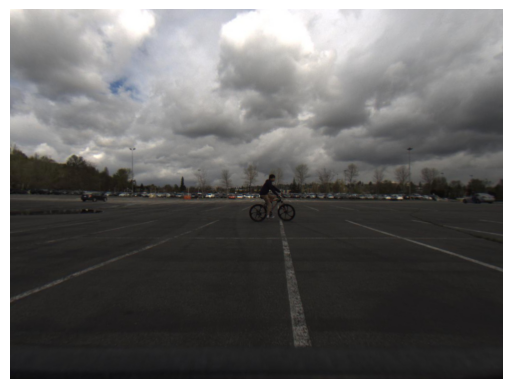

In [114]:
# Visualize the corresponding image
img_path = os.path.join(img_dir, img_file)

# Load the image
img = Image.open(img_path)
print('Image size:', img.size)
# show the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [115]:
# Range FFT
def range_fft(data, n_sample):
    # data shape: [n_sample, n_ant, n_chirp]
    hamming = np.hamming(n_sample)
    win_data = np.zeros([data.shape[0], data.shape[1], data.shape[2]], dtype=np.complex128)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            win_data[:, i, j] = np.multiply(data[:, i, j], hamming)
    fft_data_raw = np.fft.fft(win_data, n_range, axis=0)

    return fft_data_raw

In [116]:
# Range FFT
def range_fft_no_smoothing(data):
    fft_data_raw = np.fft.fft(data, n_range, axis=0)

    return fft_data_raw

In [117]:
# Reshape the data from (n_sample, n_chirp, n_rx, n_tx) to (n_sample, n_antenna, n_chirp)
ADC_data = np.transpose(ADC_data, (0, 1, 3, 2)) # (n_sample, n_chirp, n_rx, n_tx) -> (n_sample, n_chirp, n_tx, n_rx)
print('ADC data shape:', ADC_data.shape)
ADC_data = ADC_data.reshape(n_sample, n_chirp, n_ant)
ADC_data = np.transpose(ADC_data, (0, 2, 1))
print('ADC data shape:', ADC_data.shape)
# Run the range FFT
data_range_fft = range_fft(ADC_data, n_sample)
print('Range FFT data shape:', data_range_fft.shape)

# Run the range FFT without smoothing
data_range_fft_no_smoothing = range_fft_no_smoothing(ADC_data)

ADC data shape: (128, 255, 2, 4)
ADC data shape: (128, 8, 255)
Range FFT data shape: (128, 8, 255)


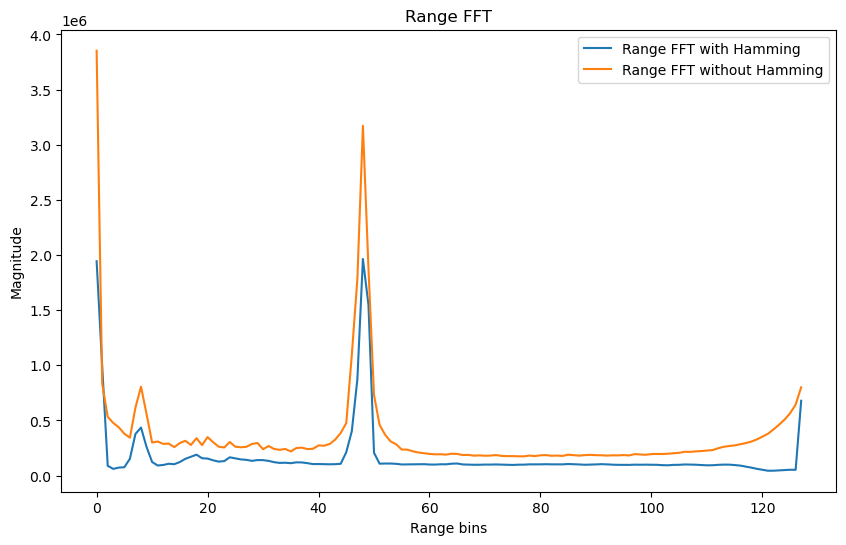

In [118]:
# Plot the magnitudes of the range bins
sum_range_fft = np.sum(np.abs(data_range_fft), axis=(1, 2))
sum_range_fft_no_smoothing = np.sum(np.abs(data_range_fft_no_smoothing), axis=(1, 2))

# Plot the magnitudes of the range bins
plt.figure(figsize=(10, 6))
plt.plot(sum_range_fft, label='Range FFT with Hamming')
plt.plot(sum_range_fft_no_smoothing, label='Range FFT without Hamming')
plt.xlabel('Range bins')
plt.ylabel('Magnitude')
plt.title('Range FFT')
plt.legend()
plt.show()

In [119]:
# Doppler FFT
def doppler_fft(data, n_vel):
    hamming_win = np.hamming(n_vel)
    win_data1 = np.zeros([data.shape[0], data.shape[1], n_vel], dtype=np.complex128)
    win_data2 = np.zeros([data.shape[0], data.shape[1], n_vel], dtype=np.complex128)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            win_data1[i, j, :] = np.multiply(data[i, j, : n_vel], hamming_win)
            win_data2[i, j, :] = np.multiply(data[i, j, n_vel - 1:], hamming_win)  # n_vel - 1: original length is 255, from n_vel to 254 only 127 values, we need 128 values

    fft_data1 = np.fft.fft(win_data1, n_vel, axis=2)
    fft_data1 = np.fft.fftshift(fft_data1, axes=2)
    sum_fft_data1 = np.sum(np.abs(fft_data1), axis=1) / n_ant  # average over antennas
    sum_fft_data1 = np.expand_dims(sum_fft_data1, axis=2)  # shape: [n_range, n_vel, 1]

    fft_data2 = np.fft.fft(win_data2, n_vel, axis=2)
    fft_data2 = np.fft.fftshift(fft_data2, axes=2)
    sum_fft_data2 = np.sum(np.abs(fft_data2), axis=1) / n_ant  # average over antennas
    sum_fft_data2 = np.expand_dims(sum_fft_data2, axis=2)  # shape: [n_range, n_vel, 1]

    # Concatenate the two halves
    fft_data = np.concatenate((sum_fft_data2, sum_fft_data1), axis=2).astype(np.float32)

    return fft_data, fft_data1, fft_data2

In [120]:
# Run the Doppler FFT
sum_data_doppler_fft, data_doppler_fft1, data_doppler_fft2 = doppler_fft(data_range_fft, n_vel)
print('Doppler FFT data shape:', sum_data_doppler_fft.shape)
print('Doppler FFT data1 shape:', data_doppler_fft1.shape, "data type:", data_doppler_fft1.dtype)
print('Doppler FFT data2 shape:', data_doppler_fft2.shape, "data type:", data_doppler_fft2.dtype)

Doppler FFT data shape: (128, 128, 2)
Doppler FFT data1 shape: (128, 8, 128) data type: complex128
Doppler FFT data2 shape: (128, 8, 128) data type: complex128


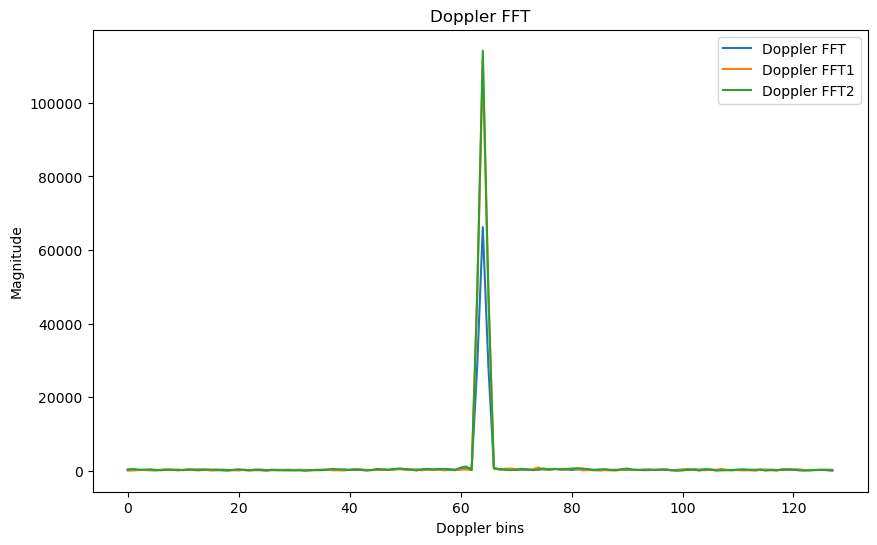

In [121]:
# Plot the magnitudes of the Doppler bins
plt.figure(figsize=(10, 6))
plt.plot(np.abs(sum_data_doppler_fft[0, :, 0]), label='Doppler FFT')
plt.plot(np.abs(data_doppler_fft1[0, 0, :]), label='Doppler FFT1')
plt.plot(np.abs(data_doppler_fft2[0, 0, :]), label='Doppler FFT2')
plt.xlabel('Doppler bins')
plt.ylabel('Magnitude')
plt.title('Doppler FFT')
plt.legend()
plt.show()

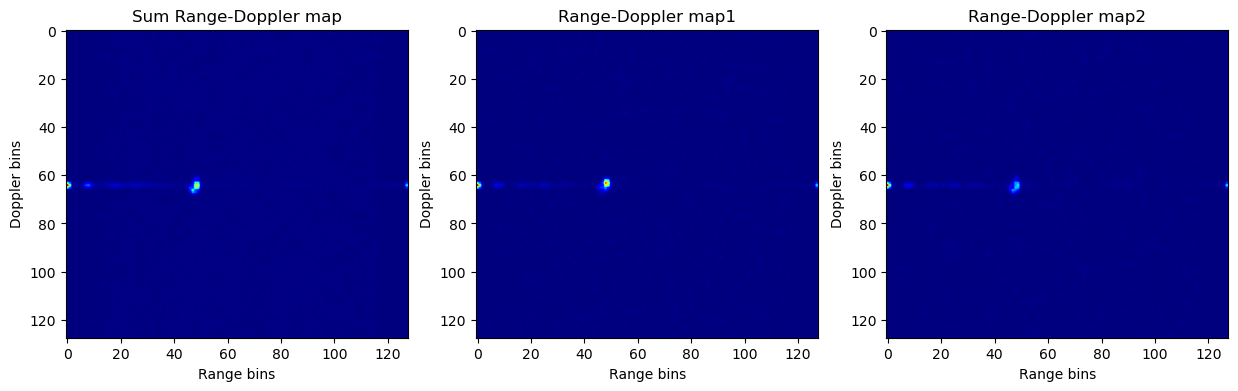

In [122]:
# Plot the Range-Doppler map
ax, fig = plt.subplots(1, 3, figsize=(15, 4))
fig[0].imshow(np.abs(sum_data_doppler_fft[:, :, 0]).T, aspect='auto', cmap='jet')
fig[0].set_title('Sum Range-Doppler map')
fig[0].set_xlabel('Range bins')
fig[0].set_ylabel('Doppler bins')
fig[0].grid(False)

fig[1].imshow(np.abs(data_doppler_fft1[:, 0, :]).T, aspect='auto', cmap='jet')
fig[1].set_title('Range-Doppler map1')
fig[1].set_xlabel('Range bins')
fig[1].set_ylabel('Doppler bins')
fig[1].grid(False)

fig[2].imshow(np.abs(data_doppler_fft2[:, 0, :]).T, aspect='auto', cmap='jet')
fig[2].set_title('Range-Doppler map2')
fig[2].set_xlabel('Range bins')
fig[2].set_ylabel('Doppler bins')
fig[2].grid(False)

plt.show()

In [123]:
# micro-Doppler FFT


In [124]:
# Angle FFT
def angle_fft_on_rd(rd_data1, rd_data2, n_ant):
    hamming_win = np.hamming(n_ant)
    win_data1 = np.zeros([rd_data1.shape[0], n_ant, rd_data1.shape[2]], dtype=np.complex128)
    win_data2 = np.zeros([rd_data2.shape[0], n_ant, rd_data2.shape[2]], dtype=np.complex128)
    for i in range(rd_data1.shape[0]):
        for j in range(rd_data1.shape[2]):
            win_data1[i, :, j] = np.multiply(rd_data1[i, :, j], hamming_win)
            win_data2[i, :, j] = np.multiply(rd_data2[i, :, j], hamming_win)

    fft_data1 = np.fft.fft(win_data1, n_angle, axis=1)
    fft_data1 = np.fft.fftshift(fft_data1, axes=1)
    sum_fft_data1 = np.sum(np.abs(fft_data1), axis=0) / rd_data1.shape[0]  # average over range bins (n_range)
    sum_fft_data1 = np.expand_dims(sum_fft_data1, axis=2)  # shape: [n_angle, n_doppler, 1]

    fft_data2 = np.fft.fft(win_data2, n_angle, axis=1)
    fft_data2 = np.fft.fftshift(fft_data2, axes=1)
    sum_fft_data2 = np.sum(np.abs(fft_data2), axis=0) / rd_data2.shape[0]  # average over range bins (n_range)
    sum_fft_data2 = np.expand_dims(sum_fft_data2, axis=2)  # shape: [n_angle, n_doppler, 1]

    # Concatenate the two halves
    fft_data = np.concatenate((sum_fft_data2, sum_fft_data1), axis=2).astype(np.float32)

    return fft_data

In [125]:
# run the angle FFT on the Range-Doppler map
angle_dopplor_map = angle_fft_on_rd(data_doppler_fft1, data_doppler_fft2, n_ant)
print('Angle FFT data shape:', angle_dopplor_map.shape)

Angle FFT data shape: (128, 128, 2)


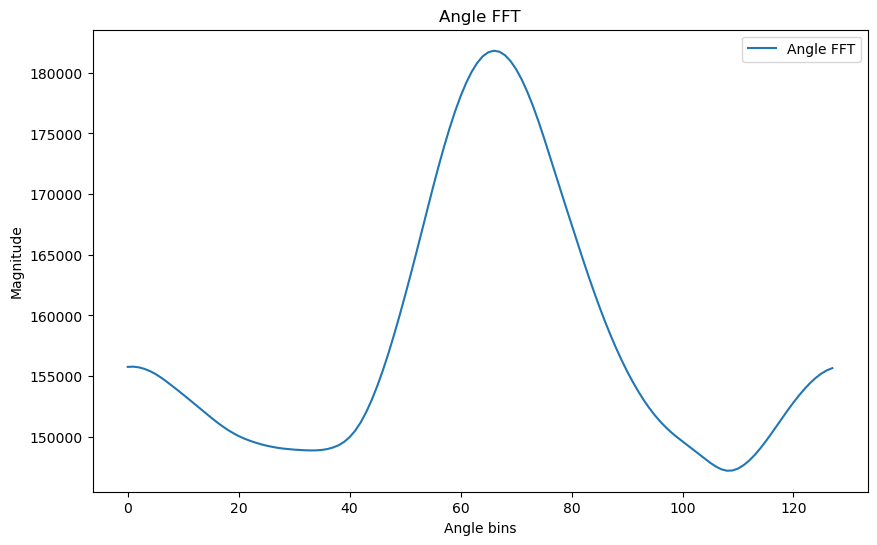

In [126]:
# Plot the magnitudes of the angle bins
plt.figure(figsize=(10, 6))
plt.plot(np.sum(np.abs(angle_dopplor_map), axis=(1,2)), label='Angle FFT')
plt.xlabel('Angle bins')
plt.ylabel('Magnitude')
plt.title('Angle FFT')
plt.legend()
plt.show()

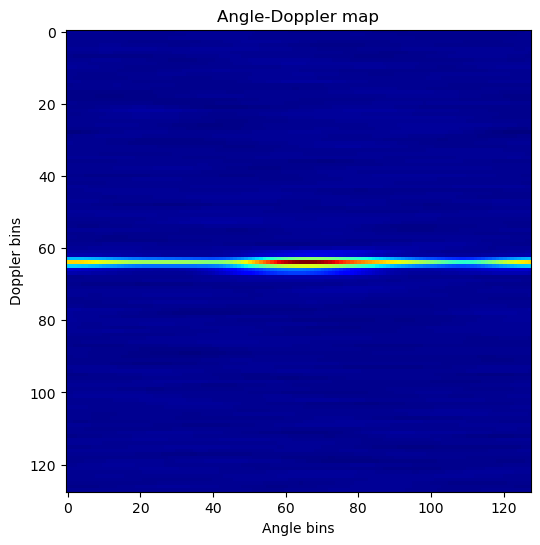

In [127]:
# Plot the Angle-Doppler map
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(angle_dopplor_map[:, :, 0]).T, aspect='auto', cmap='jet')
plt.title('Angle-Doppler map')
plt.xlabel('Angle bins')
plt.ylabel('Doppler bins')
plt.grid(False)
plt.show()

In [128]:
# Angle FFT for range-angle
def angle_fft_on_r(range_fft_data, n_ant, filter_static=False, keep_complex=False):
    hamming_win = np.hamming(n_ant)
    win_data = np.zeros([range_fft_data.shape[0], n_ant, range_fft_data.shape[2]], dtype=np.complex128)
    for i in range(range_fft_data.shape[0]):
        for j in range(range_fft_data.shape[2]):
            win_data[i, :, j] = np.multiply(range_fft_data[i, :, j], hamming_win)

    fft_data = np.fft.fft(win_data, n_angle, axis=1)
    fft_data = np.fft.fftshift(fft_data, axes=1)
    if keep_complex:
        fft_data = fft_data
    else:
        fft_data_real = np.expand_dims(fft_data.real, axis=3)  # shape: [n_range, n_angle, n_chirps, 1]
        fft_data_imag = np.expand_dims(fft_data.imag, axis=3)
        fft_data = np.concatenate((fft_data_real, fft_data_imag), axis=3).astype(np.float32)
    if filter_static:
        fft_data = fft_data - np.mean(fft_data, axis=2, keepdims=True)

    return fft_data

In [129]:
# Run the angle FFT for Range-Angle map
range_angle_map = angle_fft_on_r(data_range_fft, n_ant)
print('Range-Angle FFT data shape:', range_angle_map.shape, "data type:", range_angle_map.dtype)

Range-Angle FFT data shape: (128, 128, 255, 2) data type: float32


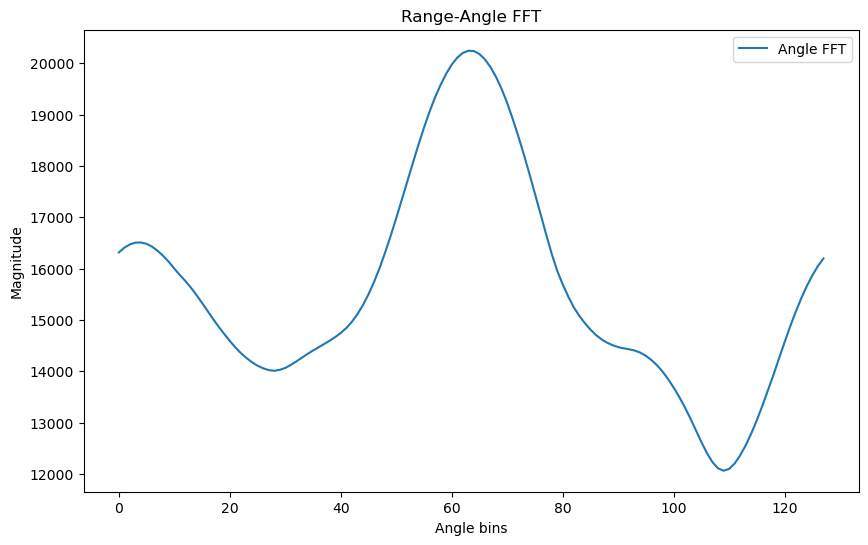

In [130]:
# Plot the magnitudes of the angle bins
plt.figure(figsize=(10, 6))
plt.plot(np.sum(np.sqrt(range_angle_map[:, :, 0, 0] ** 2 + range_angle_map[:, :, 0, 1] ** 2), axis=0), label='Angle FFT')
plt.xlabel('Angle bins')
plt.ylabel('Magnitude')
plt.title('Range-Angle FFT')
plt.legend()
plt.show()

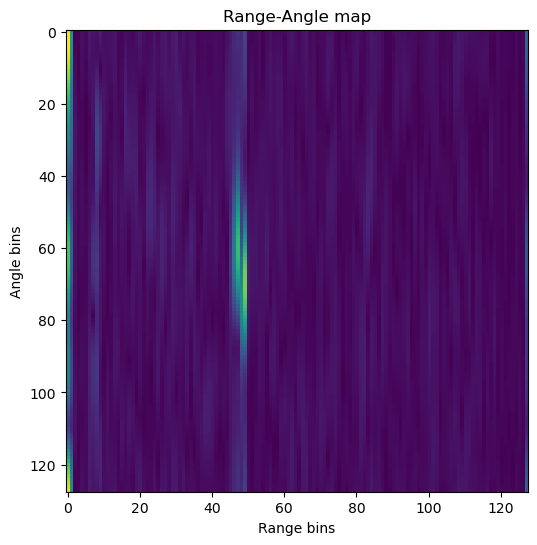

In [131]:
# Average the range-angle data over the chirps
range_angle_map_avg = np.average(range_angle_map, axis=2)

# Plot the Range-Angle map
plt.figure(figsize=(6, 6))
plt.imshow(np.sqrt(range_angle_map[:, :, 0, 0] ** 2 + range_angle_map[:, :, 0, 1] ** 2).T)
plt.title('Range-Angle map')
plt.xlabel('Range bins')
plt.ylabel('Angle bins')
plt.grid(False)
plt.show()

In [132]:
# Load .csv file
label_path = os.path.join(label_dir, label_file)
label = np.loadtxt(label_path, delimiter=',')
label = np.array(label).reshape(-1, 6)

px = label[:, 2]
py = label[:, 3]
width = label[:, 4]
length = label[:, 5]

print('Label (uid, class, px, py, width, length) (meter):', label)
print('px:', px)
print('py:', py)


Label (uid, class, px, py, width, length) (meter): [[2.20000000e+01 8.00000000e+01 8.06380000e-03 9.83851707e+00
  1.70000000e+00 6.00000000e-01]]
px: [0.0080638]
py: [9.83851707]


In [133]:
# Range Resolution (meters), bandwidth = 670 MHz
B = 670e6
R_res = scipy.constants.c / (2 * B)
print('Range resolution (meters):', R_res)

# Doppler Resolution (m/s), lambda is the wavelength, n_chirp is the number of chirps in one frame, Tc is the chirp duration, fps is the frame per second
lambda_ = scipy.constants.c / 77e9  # 77 GHz is the radar frequency
# Tc = bandwith (670MHz) / chirp_slope (21MHz/us)
fps = 30
Tc = 1 / (n_chirp * fps)
D_res = lambda_ / (2 * Tc * 255)
print('Doppler resolution (m/s):', D_res)

# Angle Resolution (degree),
A_res = 15

Range resolution (meters): 0.22372571492537313
Doppler resolution (m/s): 0.05840112818181817


In [134]:
# map the label to range-angle bins
def map_label_to_range_angle(px, py):
    # px the x-coordinate of the object center in cartesian coordinate
    # py the y-coordinate of the object center in cartesian coordinate
    # map the label to range-angle bins
    x = px
    y = py
    r = np.sqrt(x ** 2 + y ** 2)
    angle = np.arcsin(x/r) * 180 / np.pi

    # In angle axis, the center is 0 degree, so we need to shift the angle bins
    # angle = angle - n_angle // 2 * A_res

    print('r:', r, 'angle:', angle)
    range_bin = r // R_res
    angle_bin = angle // A_res * n_angle // 8
    return range_bin, angle_bin

r: [9.83852037] angle: [0.04696049]
Label (px, py) in range-angle bins: [43.] [0.]


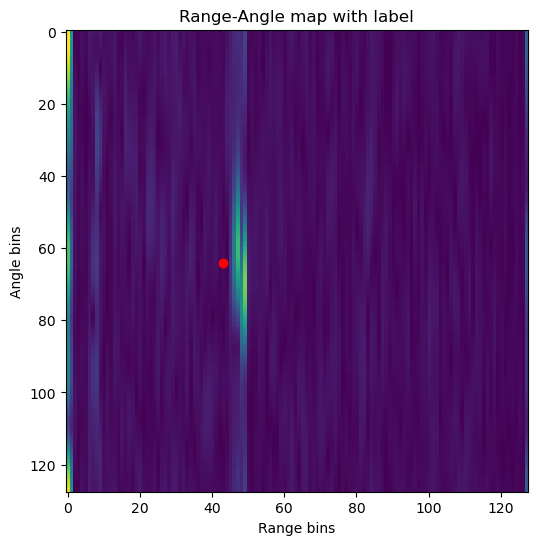

In [135]:
# map the label to range-angle bins
r_bin, a_bin = map_label_to_range_angle(px, py)
print('Label (px, py) in range-angle bins:', r_bin, a_bin)

a_bin += n_angle // 2
# for i, av in enumerate(a_bin):
#     if av < 0:
#         a_bin[i] = n_angle // 2 + av
#     else:
#         a_bin[i] = n_angle // 2 + av
# Plot the Range-Angle map with the label
plt.figure(figsize=(6, 6))
plt.imshow(np.sqrt(range_angle_map[:, :, 0, 0] ** 2 + range_angle_map[:, :, 0, 1] ** 2).T)
plt.title('Range-Angle map with label')
plt.xlabel('Range bins')
plt.ylabel('Angle bins')
plt.grid(False)
plt.plot(r_bin, a_bin, 'ro')
plt.show()

In [136]:
def DetectPeaksOSCFAR_2D(x,TrainCell_V,TrainCell_R,GuardCell_V,GuardCell_R,FA_rate):
    # Code modified from: https://github.com/ravikothari510/crossattention_radar_detector/blob/3e2169c16754a2ebe668dc3c84eeb23f331de2e2/Utils/CFAR/OS_CFAR_2D.py
    
    # x: a nparray of two dimensions. Dimension 0 consists of the range information and dimension 1 consists of the doppler information
    Xshape=x.shape
    X_V_Dim=Xshape[1]
    X_R_Dim=Xshape[0]
    
    Side_Train_V=round(TrainCell_V/2)
    Side_Guard_V=round(GuardCell_V/2)
    
    Side_Train_R=round(TrainCell_R/2)
    Side_Guard_R=round(GuardCell_R/2)
    
    Side_V=Side_Train_V+Side_Guard_V
    Side_R=Side_Train_R+Side_Guard_R
    
    
    alpha_V = TrainCell_V*(FA_rate**(-1/TrainCell_V) - 1) # threshold factor
    alpha_R = TrainCell_R*(FA_rate**(-1/TrainCell_R) - 1) # threshold factor

    
    peaks_ind=list()
    peaks_val=list()
    Threshold=list()
    cfar_out = np.zeros_like(x)

    for j in range(Side_R,X_R_Dim-Side_R): 
        for i in range(Side_V,X_V_Dim-Side_V):
            if j!=j-Side_R+np.argmax(x[j-Side_R:j+Side_R+1,i]):
                continue
            
            if i!=i-Side_V+np.argmax(x[j,i-Side_V:i+Side_V+1]):
                continue
            SortTrainSeq_V = np.msort(x[j,i-Side_V:i+Side_V+1])
            SortTrainSeq_R = np.msort(x[j-Side_R:j+Side_R+1,i])

            Pnoise = ( SortTrainSeq_V[(SortTrainSeq_V.size)//2] +  SortTrainSeq_R[(SortTrainSeq_R.size)//2] ) / 2
             
            Threshold.append(Pnoise*(alpha_V+alpha_R)/2)
            ThresholdA=Pnoise*(alpha_V+alpha_R)/2
            if x[j,i] > ThresholdA:
                peaks_ind.append([j,i])
                peaks_val.append(x[j,i])  
            
                cfar_out[j,i] = 1
             
    
    peaks_ind = np.array(peaks_ind, dtype=int) 
    Threshold = np.array(Threshold)             
    return peaks_ind, cfar_out

For CFAR, it's quite tricky to find the appropriate false alarm rate (FA_rate), need manually adjust it. If the FA_rate is too high, the detection will be too sensitive and the noise will be detected as a target. If the FA_rate is too low, the detection will be too conservative and the target will be missed.

Number of detected targets: 2


/tmp/ipykernel_1294704/3551986547.py:35: DeprecationWarning: msort is deprecated, use np.sort(a, axis=0) instead
  SortTrainSeq_V = np.msort(x[j,i-Side_V:i+Side_V+1])
/tmp/ipykernel_1294704/3551986547.py:36: DeprecationWarning: msort is deprecated, use np.sort(a, axis=0) instead
  SortTrainSeq_R = np.msort(x[j-Side_R:j+Side_R+1,i])


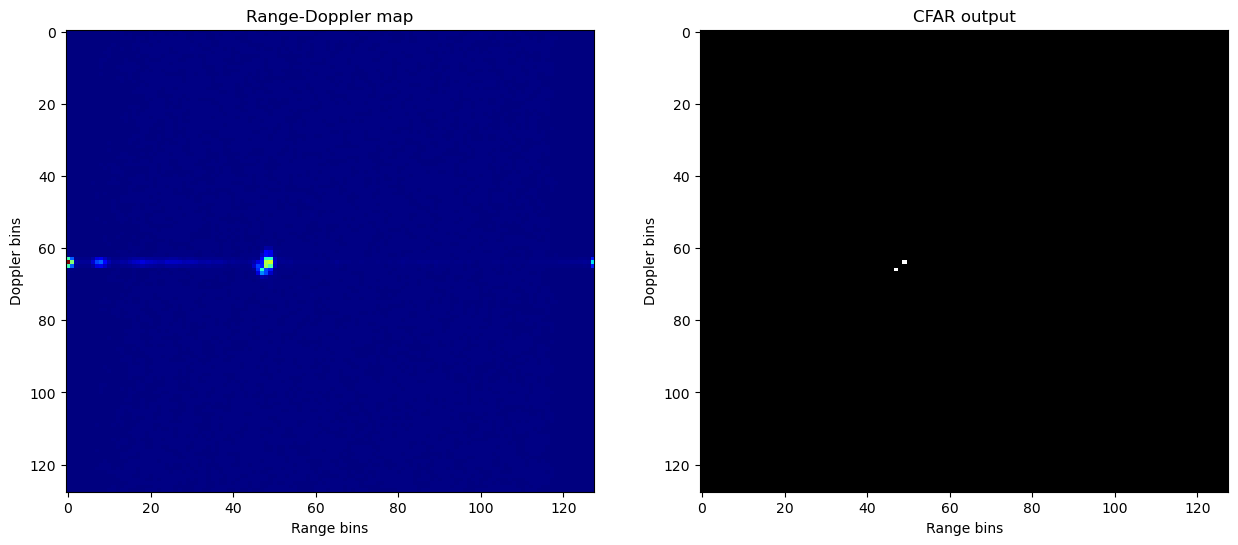

In [137]:
# Apply DetectPeaksOSCFAR_2D on the Range-Doppler map
peak_ind, cfar_out = DetectPeaksOSCFAR_2D(np.abs(sum_data_doppler_fft[:, :, 0]), 10, 2, 10, 2, 0.08)
print('Number of detected targets:', peak_ind.shape[0])

# Plot the Range-Doppler map with the CFAR output
ax, fig = plt.subplots(1, 2, figsize=(15, 6))
fig[0].imshow(np.abs(sum_data_doppler_fft[:, :, 0]).T, aspect='auto', cmap='jet')
fig[0].set_title('Range-Doppler map')
fig[0].set_xlabel('Range bins')
fig[0].set_ylabel('Doppler bins')
fig[0].grid(False)

fig[1].imshow(cfar_out.T, aspect='auto', cmap='gray')
fig[1].set_title('CFAR output')
fig[1].set_xlabel('Range bins')
fig[1].set_ylabel('Doppler bins')
fig[1].grid(False)

plt.show()

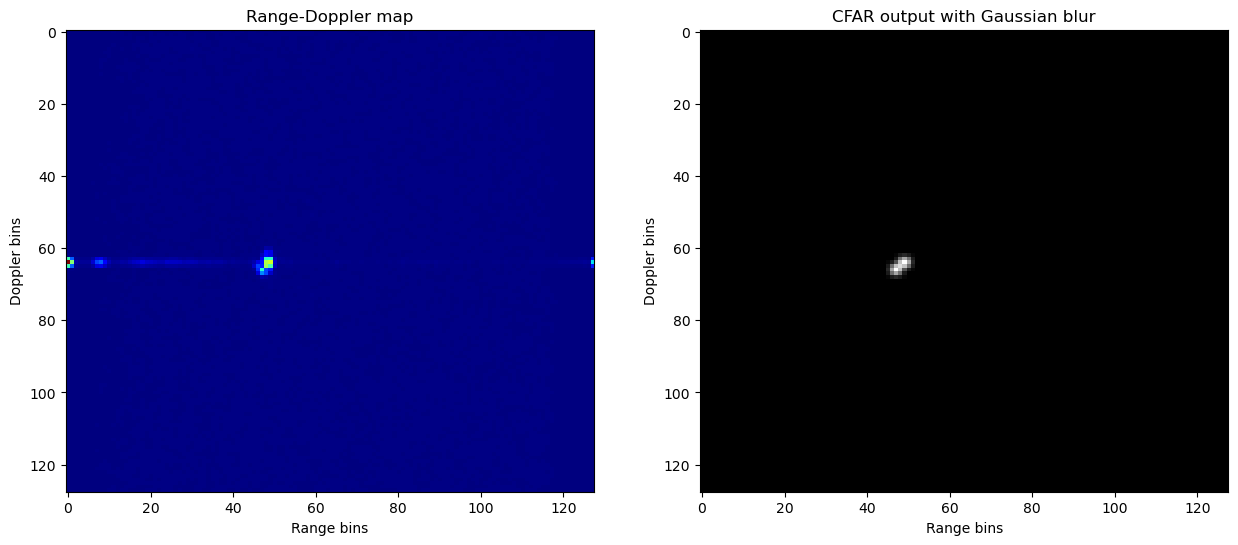

In [138]:
# Apply a Gaussian blue on the CFAR output
cfar_out_gaussian = cv2.GaussianBlur(cfar_out, (5, 5), 0)

# Plot the Range-Doppler map with the CFAR output
ax, fig = plt.subplots(1, 2, figsize=(15, 6))
fig[0].imshow(np.abs(sum_data_doppler_fft[:, :, 0]).T, aspect='auto', cmap='jet')
fig[0].set_title('Range-Doppler map')
fig[0].set_xlabel('Range bins')
fig[0].set_ylabel('Doppler bins')
fig[0].grid(False)

fig[1].imshow(cfar_out_gaussian.T, aspect='auto', cmap='gray')
fig[1].set_title('CFAR output with Gaussian blur')
fig[1].set_xlabel('Range bins')
fig[1].set_ylabel('Doppler bins')
fig[1].grid(False)

plt.show()

Number of detected targets: 2


/tmp/ipykernel_1294704/3551986547.py:35: DeprecationWarning: msort is deprecated, use np.sort(a, axis=0) instead
  SortTrainSeq_V = np.msort(x[j,i-Side_V:i+Side_V+1])
/tmp/ipykernel_1294704/3551986547.py:36: DeprecationWarning: msort is deprecated, use np.sort(a, axis=0) instead
  SortTrainSeq_R = np.msort(x[j-Side_R:j+Side_R+1,i])


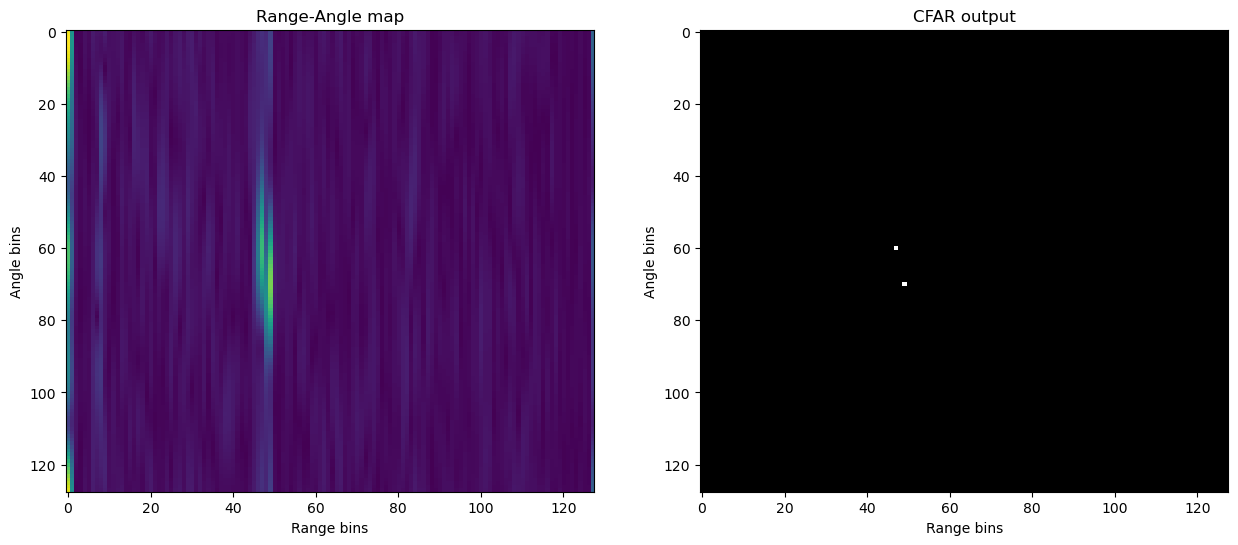

In [139]:
# Apply CFAR on the Range-Angle map
peak_ind_ra, cfar_out_ra = DetectPeaksOSCFAR_2D(np.sqrt(range_angle_map[:, :, 0, 0] ** 2 + range_angle_map[:, :, 0, 1] ** 2), 10, 10, 10, 10, 0.205)
print('Number of detected targets:', peak_ind_ra.shape[0])

# Plot the Range-Angle map with the CFAR output
ax, fig = plt.subplots(1, 2, figsize=(15, 6))
fig[0].imshow(np.sqrt(range_angle_map[:, :, 0, 0] ** 2 + range_angle_map[:, :, 0, 1] ** 2).T, aspect='auto')
fig[0].set_title('Range-Angle map')
fig[0].set_xlabel('Range bins')
fig[0].set_ylabel('Angle bins')
fig[0].grid(False)

fig[1].imshow(cfar_out_ra.T, aspect='auto', cmap='gray')
fig[1].set_title('CFAR output')
fig[1].set_xlabel('Range bins')
fig[1].set_ylabel('Angle bins')
fig[1].grid(False)

plt.show()

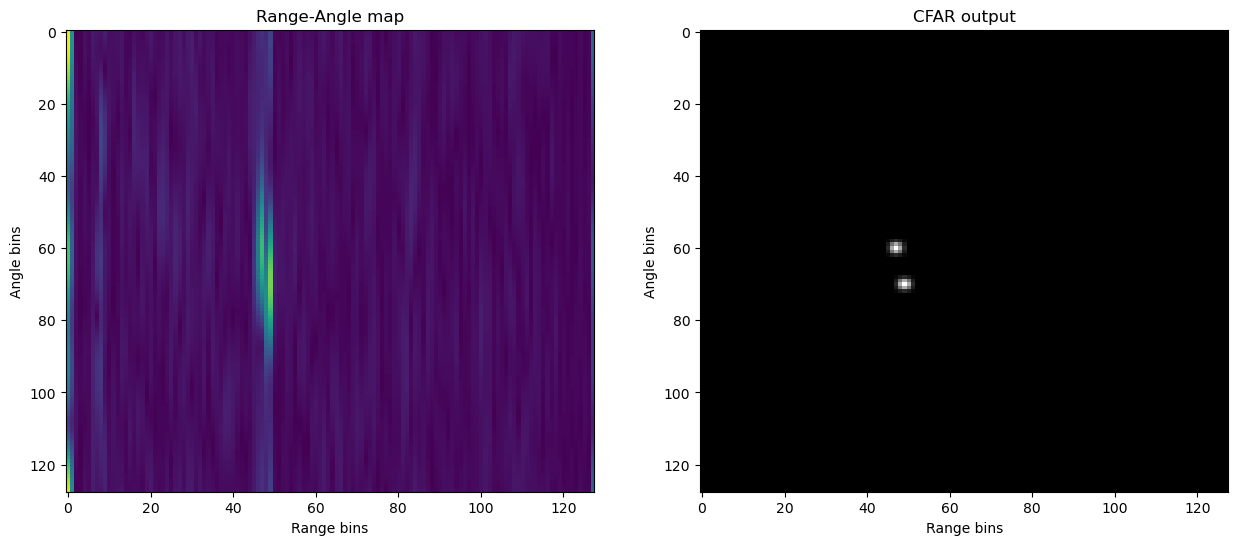

In [140]:
# Apply a Gaussian blue on the CFAR output
cfar_out_ra_gaussian = cv2.GaussianBlur(cfar_out_ra, (5, 5), 0)

# Plot the Range-Angle map with the CFAR output
ax, fig = plt.subplots(1, 2, figsize=(15, 6))
fig[0].imshow(np.sqrt(range_angle_map[:, :, 0, 0] ** 2 + range_angle_map[:, :, 0, 1] ** 2).T, aspect='auto')
fig[0].set_title('Range-Angle map')
fig[0].set_xlabel('Range bins')
fig[0].set_ylabel('Angle bins')
fig[0].grid(False)

fig[1].imshow(cfar_out_ra_gaussian.T, aspect='auto', cmap='gray')
fig[1].set_title('CFAR output')
fig[1].set_xlabel('Range bins')
fig[1].set_ylabel('Angle bins')
fig[1].grid(False)

plt.show()

Here is an alternative way of CFAR:  

https://github.com/ali20480/RadarDetector/blob/main/DetectorAssessment.py